# Importing all the important libraries

In [50]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import PIL
import PIL.Image
from tensorflow import keras

In [51]:
# Root path for dataset
root_path = '../input/cnnmelanomadetection/Skin cancer ISIC The International Skin Imaging Collaboration/'

In [52]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(root_path+"Train")
data_dir_test = pathlib.Path(root_path+'Test')

In [53]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Count of train images: " + str(image_count_train))
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Count of test images: " + str(image_count_test))

Count of train images: 2239
Count of test images: 118


## Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader

In [54]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [55]:
# Train Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [56]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [57]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


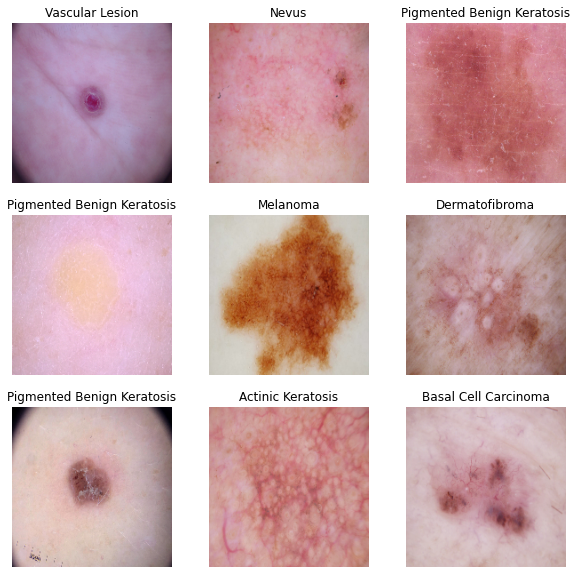

In [58]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]].title())
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [59]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model


In [60]:
# model architecture
model = tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(scale = 1./255, input_shape = (180,180,3)),
    keras.layers.Conv2D(32,3,padding='same',activation= 'relu'),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Conv2D(64,3,padding='same',activation= 'relu'),
    keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dense(9,activation='softmax')
])

### Compile the model

In [61]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Train the model


In [62]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2022-11-16 17:49:28.432510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:177] Filling up shuffle buffer (this may take a while): 28 of 1000


 4/56 [=>............................] - ETA: 2s - loss: 14.6059 - accuracy: 0.1439 

2022-11-16 17:49:33.896183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:230] Shuffle buffer filled.


56/56 [==============================] - 22s 111ms/step - loss: 6.5655 - accuracy: 0.1673 - val_loss: 1.9440 - val_accuracy: 0.2617
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.8060 - accuracy: 0.3368 - val_loss: 1.7143 - val_accuracy: 0.3758
Epoch 3/20
56/56 [==============================] - 2s 40ms/step - loss: 1.5954 - accuracy: 0.4299 - val_loss: 1.6190 - val_accuracy: 0.4519
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4380 - accuracy: 0.4993 - val_loss: 1.4570 - val_accuracy: 0.5213
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.2566 - accuracy: 0.5586 - val_loss: 1.4961 - val_accuracy: 0.4989
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.1351 - accuracy: 0.6091 - val_loss: 1.4865 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 0.9936 - accuracy: 0.6580 - val_loss: 1.5710 - val_accuracy: 0.5078
Epoch 8/20
56/56 [====

### Visualizing training results

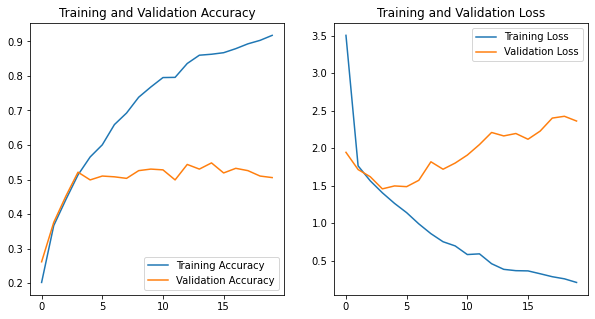

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

In [100]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 4s 103ms/step - loss: 1.6244 - accuracy: 0.5257
Accuracy:  0.6400669813156128
Validation Accuracy:  0.5257270932197571
Loss:  0.9826764464378357
Validation Loss 1.6244317293167114


Here we can see that in model is overfitting due to:
- In accuracy graph, training is very high where validation is half of it.

Now we need to chose right data augumentation strategy

In [64]:
_data = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.2),
  keras.layers.experimental.preprocessing.RandomZoom(height_factor=(0.2,0.3), width_factor=(0.2,0.3))  
])

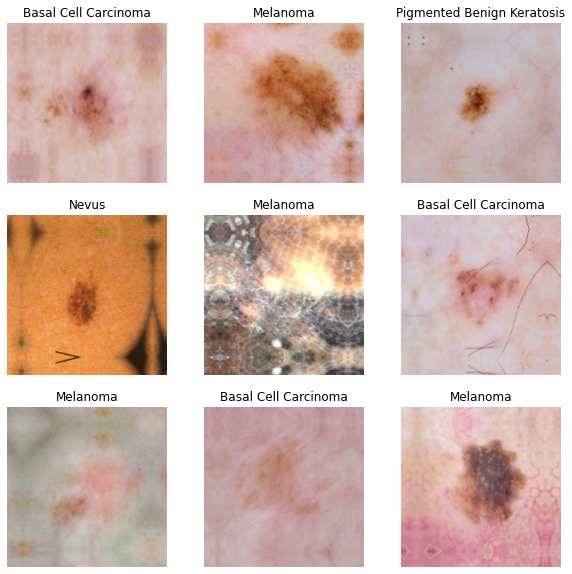

In [65]:
# visualize if the augmentation strategy works for one instance of training image
plt.figure(figsize=(10, 10))
for img, labels in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(_data(img)[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]].title())
        plt.axis("off")

### Re-create Model

In [66]:
num_classes = 9
model = tf.keras.Sequential([
  _data,
  keras.layers.experimental.preprocessing.Rescaling(1./255),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.3),
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(num_classes)
])

### Re-compile the model

In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

### Re-train model

In [68]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 47ms/step - loss: 6.4698 - accuracy: 0.1824 - val_loss: 1.8242 - val_accuracy: 0.3647
Epoch 2/20
56/56 [==============================] - 2s 45ms/step - loss: 1.9213 - accuracy: 0.2950 - val_loss: 1.7817 - val_accuracy: 0.3915
Epoch 3/20
56/56 [==============================] - 2s 43ms/step - loss: 1.7689 - accuracy: 0.3657 - val_loss: 1.6765 - val_accuracy: 0.3490
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.5870 - accuracy: 0.4168 - val_loss: 1.4857 - val_accuracy: 0.5034
Epoch 5/20
56/56 [==============================] - 2s 44ms/step - loss: 1.5348 - accuracy: 0.4445 - val_loss: 1.4361 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4367 - accuracy: 0.4927 - val_loss: 1.4870 - val_accuracy: 0.4922
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4840 - accuracy: 0.4711 - val_loss: 1.4678 - val_accuracy: 0.4944
Epoch 8/20
56

### Visualizing training results

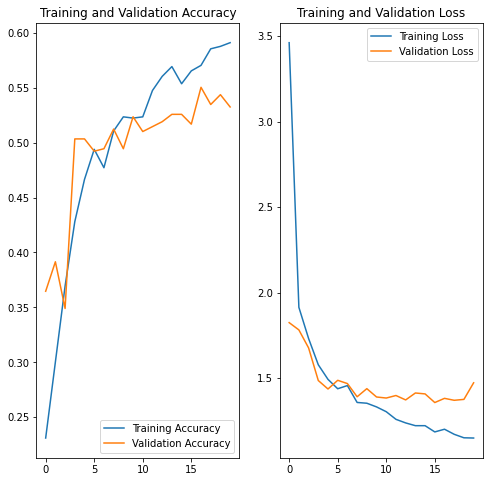

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### FIndings

In [98]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 4s 100ms/step - loss: 1.6244 - accuracy: 0.5257
Accuracy:  0.6400669813156128
Validation Accuracy:  0.5257270932197571
Loss:  0.9826765060424805
Validation Loss 1.6244317293167114


In [70]:
_path=[]
_label=[]
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    _path.append(str(j))
    _label.append(i)
dataframe_dict_original = dict(zip(_path, _label))
df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
print(df.shape)

(2239, 2)


In [71]:
df.head()

,Path,Label
0,../input/cnnmelanomadetection/Skin cancer ISIC...,actinic keratosis
1,../input/cnnmelanomadetection/Skin cancer ISIC...,actinic keratosis
2,../input/cnnmelanomadetection/Skin cancer ISIC...,actinic keratosis
3,../input/cnnmelanomadetection/Skin cancer ISIC...,actinic keratosis
4,../input/cnnmelanomadetection/Skin cancer ISIC...,actinic keratosis


<BarContainer object of 9 artists>

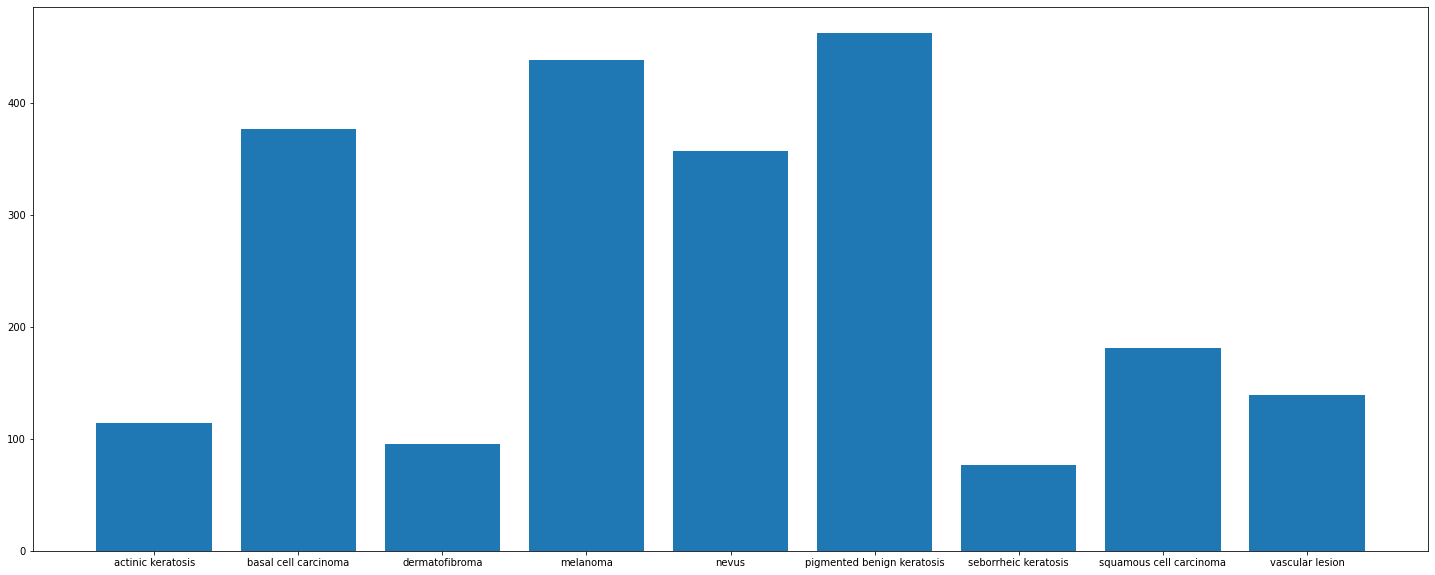

In [72]:
class_count=[]
for i in class_names:
    class_count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,class_count)

### Rectify the class imbalance

In [73]:
!pip install Augmentor

In [74]:
import Augmentor

In [75]:
path_to_training_dataset = '../input/cnnmelanomadetection/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='/kaggle/working/'+i+'/output/')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/actinic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD2C214E950>: 100%|██████████| 1000/1000 [00:31<00:00, 31.69 Samples/s]                 


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/basal cell carcinoma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD2C202DA10>: 100%|██████████| 1000/1000 [00:31<00:00, 31.90 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/dermatofibroma/output/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FD2C236F710>: 100%|██████████| 1000/1000 [00:31<00:00, 31.26 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/output/.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FD2C303E750>: 100%|██████████| 1000/1000 [02:55<00:00,  5.71 Samples/s]                 


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/nevus/output/.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FD2C2276BD0>: 100%|██████████| 1000/1000 [02:50<00:00,  5.85 Samples/s]                 


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/pigmented benign keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD2C341FFD0>: 100%|██████████| 1000/1000 [00:31<00:00, 31.42 Samples/s]                 


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/seborrheic keratosis/output/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FD2C2C28D50>: 100%|██████████| 1000/1000 [01:19<00:00, 12.61 Samples/s]                 


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/squamous cell carcinoma/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD2C2FC0050>: 100%|██████████| 1000/1000 [00:31<00:00, 32.00 Samples/s]                 


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/vascular lesion/output/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FD2C3401E90>: 100%|██████████| 1000/1000 [00:31<00:00, 31.91 Samples/s]                 


### Lets see the distribution of augmented data after adding new images to the original training data.

In [84]:
output_dir = pathlib.Path('/kaggle/working/')

In [85]:
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

12220


In [86]:
from glob import glob
path_list = [x for x in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
len(path_list)

12220

In [87]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(output_dir, '*','output', '*.jpg'))]
len(lesion_list_new)

12220

In [88]:
_new_df = dict(zip(path_list, lesion_list_new))

In [89]:
df2 = pd.DataFrame(list(_new_df.items()),columns = ['Path','Label'])
new_df = df.append(df2)

In [90]:
new_df['Label'].value_counts()

basal cell carcinoma          2376
actinic keratosis             2114
dermatofibroma                2095
melanoma                      1658
pigmented benign keratosis    1462
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor


In [91]:
batch_size = 32
img_height = 180
img_width = 180

In [93]:
train_ds = keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [94]:
val_ds = keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation',
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


### Create the model


In [95]:
num_classes = 9
model = keras.Sequential([
  _data,
  keras.layers.experimental.preprocessing.Rescaling(1./255),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Dropout(0.3),
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dropout(0.2),
  keras.layers.Dense(num_classes, activation='softmax')
])

### Compile the model

In [96]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [97]:
epochs = 50
history50 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
56/56 [==============================] - 21s 326ms/step - loss: 7.5512 - accuracy: 0.2008 - val_loss: 1.9415 - val_accuracy: 0.3311
Epoch 2/50
56/56 [==============================] - 20s 331ms/step - loss: 1.8735 - accuracy: 0.2953 - val_loss: 1.6542 - val_accuracy: 0.4206
Epoch 3/50
56/56 [==============================] - 20s 318ms/step - loss: 1.6047 - accuracy: 0.4357 - val_loss: 1.5409 - val_accuracy: 0.4631
Epoch 4/50
56/56 [==============================] - 20s 325ms/step - loss: 1.5107 - accuracy: 0.4591 - val_loss: 1.5663 - val_accuracy: 0.4340
Epoch 5/50
56/56 [==============================] - 21s 333ms/step - loss: 1.4566 - accuracy: 0.4811 - val_loss: 1.4137 - val_accuracy: 0.5011
Epoch 6/50
56/56 [==============================] - 20s 324ms/step - loss: 1.4285 - accuracy: 0.5091 - val_loss: 1.4162 - val_accuracy: 0.5101
Epoch 7/50
56/56 [==============================] - 20s 326ms/step - loss: 1.4204 - accuracy: 0.5038 - val_loss: 1.4654 - val_accuracy: 0.5011

### Visualizing training results

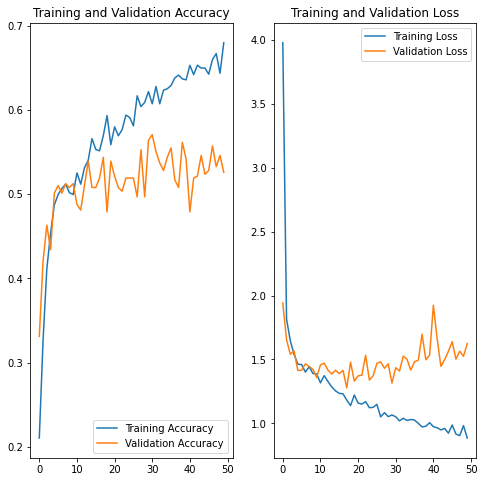

In [101]:
acc = history50.history['accuracy']
val_acc = history50.history['val_accuracy']

loss = history50.history['loss']
val_loss = history50.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Did you get rid of underfitting/overfitting? Did class rebalance help?

We can see that last model, class rebalance helped in reducing overfitting.